In [2]:
# Calling libraries:
from __future__ import division
%matplotlib inline
import numpy as np, time, matplotlib.pyplot as plt, math, pandas, numpy.random as npr, pystan as ps, pickle
from pylab import plot, show, legend
from functions_garch import *

In [3]:
file = open("/xtmp/DC-BATS_data/garch/full_mcmc.pkl", "rb")
trace_full = pickle.load(file)

In [4]:
m = 10
n_mcmc, p = np.shape(trace_full['beta'])
q = np.shape(trace_full['alpha'])[1]
d = np.shape(trace_full['b'])[1]

beta_sample = np.zeros((m,n_mcmc,p))
alpha_sample = np.zeros((m,n_mcmc,q))
b_sample = np.zeros((m,n_mcmc,d))
omega_sample = np.zeros((m,n_mcmc))

beta_mle = np.zeros((m,p))
alpha_mle = np.zeros((m,q))
b_mle = np.zeros((m,d))
omega_mle = np.zeros(m)

for i in range(m) :
    file = open("/xtmp/DC-BATS_data/garch/mcmc_wb_chunk"+str(i+1)+".pkl", "rb")
    trace_dc = pickle.load(file)
    beta_sample[i] = trace_dc['beta']
    alpha_sample[i] = trace_dc['alpha']
    b_sample[i] = trace_dc['b']
    omega_sample[i] = trace_dc['omega']
    
    file = open("/xtmp/DC-BATS_data/garch/mle_chunk"+str(i+1)+".pkl", "rb")
    mle_dc = pickle.load(file)
    beta_mle[i] = mle_dc['beta']
    alpha_mle[i] = mle_dc['alpha']
    b_mle[i] = mle_dc['b']
    omega_mle[i] = mle_dc['omega']    

In [5]:
beta_dpMC = double_parallel_MC(beta_sample, beta_mle)
alpha_dpMC = double_parallel_MC(alpha_sample, alpha_mle)
b_dpMC = double_parallel_MC(b_sample, b_mle)
omega_dpMC = double_parallel_MC(np.reshape(omega_sample,[*np.shape(omega_sample),1]), 
                                np.reshape(omega_mle,[*np.shape(omega_mle),1]))

100%|██████████| 5000/5000 [00:00<00:00, 44216.57it/s]


In [6]:
np.shape(beta_dpMC)

(10, 5000, 5)

In [7]:
beta_ci_dpMC = np.percentile(np.reshape(beta_dpMC, [np.prod(np.shape(beta_dpMC)[0:2]),np.shape(beta_dpMC)[-1]]), 
                              q=[2.5,97.5], axis=0)
alpha_ci_dpMC = np.percentile(np.reshape(alpha_dpMC, [np.prod(np.shape(alpha_dpMC)[0:2]),np.shape(alpha_dpMC)[-1]]), 
                              q=[2.5,97.5], axis=0)
b_ci_dpMC = np.percentile(np.reshape(b_dpMC, [np.prod(np.shape(b_dpMC)[0:2]),np.shape(b_dpMC)[-1]]), 
                          q=[2.5,97.5], axis=0)
omega_ci_dpMC = np.percentile(np.reshape(omega_dpMC, [np.prod(np.shape(omega_dpMC)[0:2]),np.shape(omega_dpMC)[-1]]), 
                          q=[2.5,97.5], axis=0)

In [8]:
file = open("/xtmp/DC-BATS_data/garch/full_mcmc.pkl", "rb")
trace = pickle.load(file)

b_ci_full = np.percentile(trace['b'],axis=0,q=[2.5,97.5])
beta_ci_full = np.percentile(trace['beta'],axis=0,q=[2.5,97.5])
alpha_ci_full = np.percentile(trace['alpha'],axis=0,q=[2.5,97.5])
omega_ci_full = np.percentile(trace['omega'],axis=0,q=[2.5,97.5])

b_ci_dc = np.zeros((2,d))
beta_ci_dc = np.zeros((2,p))
alpha_ci_dc = np.zeros((2,q))
omega_ci_dc = np.zeros(2)
for i in range(m) :
    file = open("/xtmp/DC-BATS_data/garch/mcmc_wb_chunk"+str(i+1)+".pkl", "rb")
    trace = pickle.load(file)
    b_ci_dc += np.percentile(trace['b'],axis=0,q=[2.5,97.5])/m
    beta_ci_dc += np.percentile(trace['beta'],axis=0,q=[2.5,97.5])/m
    alpha_ci_dc += np.percentile(trace['alpha'],axis=0,q=[2.5,97.5])/m
    omega_ci_dc += np.percentile(trace['omega'],axis=0,q=[2.5,97.5])/m

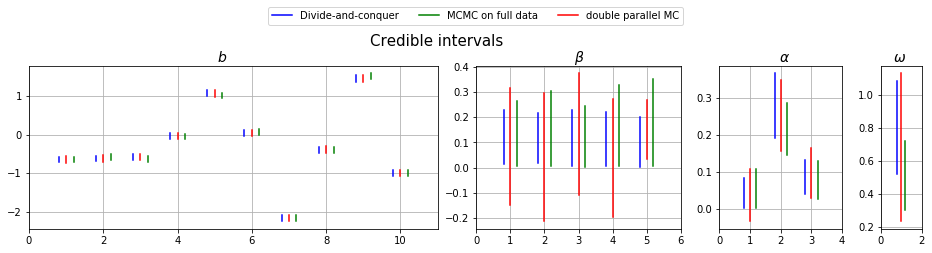

In [25]:
plt.rcParams['axes.grid'] = True
f, (a0, a1, a2, a3) = plt.subplots(1, 4, gridspec_kw={'width_ratios': [d, p, q, 1]}, figsize=(16,3))

# a0.plot(np.arange(1,d+1), b, "ro")
for i in range(d) :
    a0.plot([i+0.8,i+0.8], b_ci_dc[:,i], "b-")
    a0.plot([i+1.2,i+1.2], b_ci_full[:,i], "g-")
    a0.plot([i+1,i+1], b_ci_dpMC[:,i], "r-")
a0.axis(xmin=0,xmax=d+1)

# a1.plot(np.arange(1,p+1), beta, "ro")
for i in range(p) :
    a1.plot([i+0.8,i+0.8], beta_ci_dc[:,i], "b-")
    a1.plot([i+1.2,i+1.2], beta_ci_full[:,i], "g-")
    a1.plot([i+1,i+1], beta_ci_dpMC[:,i], "r-")
a1.axis(xmin=0,xmax=p+1)

# a2.plot(np.arange(1,q+1), alpha, "ro")
for i in range(q) :
    a2.plot([i+0.8,i+0.8], alpha_ci_dc[:,i], "b-")
    a2.plot([i+1.2,i+1.2], alpha_ci_full[:,i], "g-")
    a2.plot([i+1,i+1], alpha_ci_dpMC[:,i], "r-")
a2.axis(xmin=0,xmax=q+1)

# a3.plot(1, omega, "ro")
a3.plot([0.8,0.8], omega_ci_dc, "b-", label="Divide-and-conquer")
a3.plot([1.2,1.2], omega_ci_full, "g-", label="MCMC on full data")
a3.plot([1,1], omega_ci_dpMC, "r-", label="double parallel MC")
a3.axis(xmin=0,xmax=2)

plt.text(x=-32.5, y=1.2, s=r"$b$", fontsize=14)
plt.text(x=-15, y=1.2, s=r"$\beta$", fontsize=14)
plt.text(x=-5, y=1.2, s=r"$\alpha$", fontsize=14)
plt.text(x=0.6, y=1.2, s=r"$\omega$", fontsize=14)
plt.text(x=-25, y=1.3, s=r"Credible intervals", fontsize=15)
plt.legend(ncol=3, loc=(-15,1.25))
f.savefig('garch_CI.pdf', bbox_inches='tight', dpi=2000)